In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from munch import Munch
from PIL import Image
import datasets
import models
import utils
from pose_estimation import models as pose_models
from pose_estimation import utils as pose_utils
from segmentation import models as segm_models
import yaml

In [2]:
data_root = 'data/OilChangeDataset'
ann_file = '20171103_OilChange.json'
camera_name = 'floating_kinect1'
segm_config_path = 'segmentation/pretrained/drn_d_22_OilChange/config.yml'
pose_config_path = 'pose_estimation/pretrained/floating_kinect1_mask/config.yml'
blender_path = '/usr/bin/blender'

In [3]:
with open(segm_config_path, 'r') as f:
    segm_cfg = yaml.safe_load(f)
    segm_cfg['training']['resume'] = os.path.join('segmentation', segm_cfg['training']['resume'])
with open(pose_config_path, 'r') as f:
    pose_cfg = yaml.safe_load(f)
    pose_cfg['training']['resume'] = os.path.join('pose_estimation', pose_cfg['training']['resume'])
    #pose_cfg.training.resume = os.path.join('pose_estimation', pose_cfg.training.resume)


In [4]:
cudnn.benchmark = True

In [5]:
segm_model = segm_models.DRNSeg(segm_cfg['arch'], segm_cfg['data']['classes'], None, pretrained=True)
segm_model = torch.nn.DataParallel(segm_model).cuda()
segm_checkpoint = torch.load(segm_cfg['training']['resume'])
segm_model.load_state_dict(segm_checkpoint['state_dict'])
print("=> loaded checkpoint '{}' (epoch {})".format(segm_cfg['training']['resume'], segm_checkpoint['epoch']))

=> loaded checkpoint 'segmentation/pretrained/drn_d_22_OilChange/checkpoint_00000900.pth.tar' (epoch 900)


In [6]:
pose_model = pose_models.Model(pose_cfg['arch'])
pose_model = torch.nn.DataParallel(pose_model).cuda()
pose_checkpoint = torch.load(pose_cfg['training']['resume'])
pose_model.load_state_dict(pose_checkpoint['state_dict'])
print("=> loaded checkpoint '{}' (epoch {})".format(pose_cfg['training']['resume'], pose_checkpoint['epoch']))

=> loaded checkpoint 'pose_estimation/pretrained/floating_kinect1_mask/checkpoint_00002100.pth.tar' (epoch 2100)


In [7]:
transform = transforms.ToTensor()
val_dataset = datasets.VisualizationDataset(
    data_root, 'val_' + ann_file, camera_name, transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
using camera: floating_kinect1


In [8]:
object_ids = utils.get_object_ids(data_root, 'val_' + ann_file, pose_cfg['data']['objects'])
model = models.EndToEndModel(segm_model, pose_model, pose_cfg['data']['objects'], object_ids).cuda()
model.eval();

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [9]:
# for segmentation visualization
object_colormap = utils.get_object_colormap(data_root, 'val_' + ann_file, pose_cfg['data']['objects'])
alpha = 0.6

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [11]:
# for pose estimation visualization
camera_parameters = pose_utils.get_camera_parameters(data_root, ann_file, camera_name)
model_paths = pose_utils.get_model_paths(data_root, ann_file, pose_cfg['data']['objects'])
pose_renderers = {
    object_name: pose_utils.PoseRenderer(blender_path, camera_parameters, model_path, 'object')
    for object_name, model_path in zip(pose_cfg['data']['objects'], model_paths)
}
object_colors = utils.get_object_colors(data_root, 'val_' + ann_file, pose_cfg['data']['objects'])

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


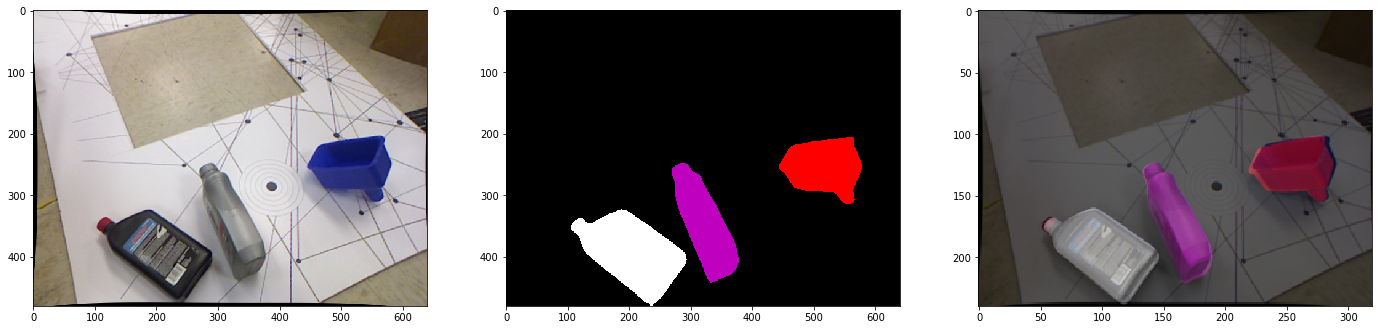

detected objects: ['oil_bottle', 'fluid_bottle', 'blue_funnel']



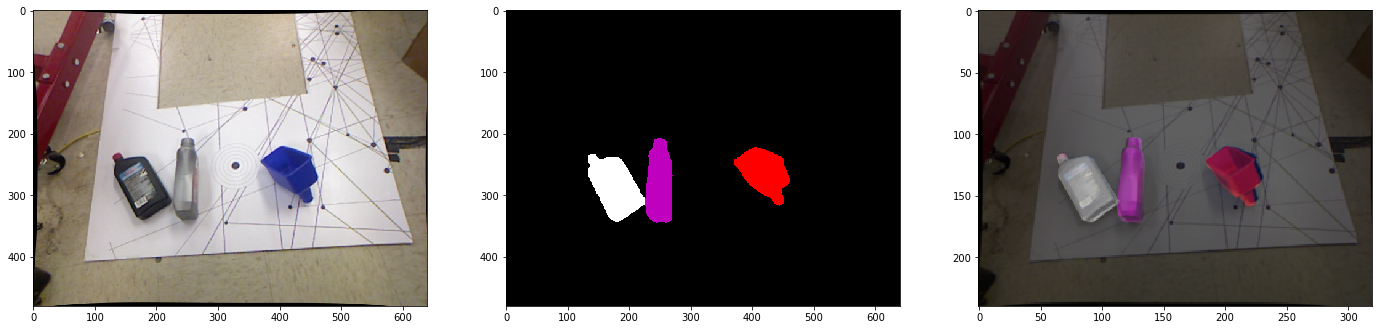

detected objects: ['oil_bottle', 'fluid_bottle', 'blue_funnel']



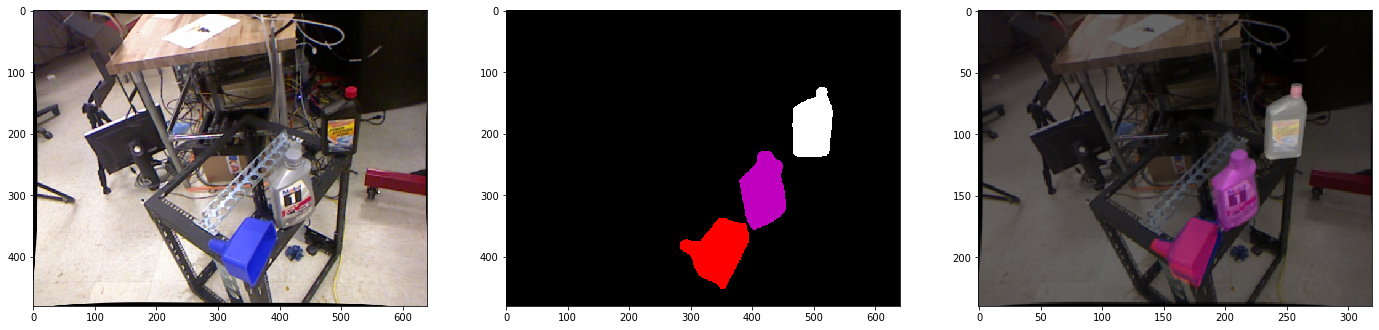

detected objects: ['oil_bottle', 'fluid_bottle', 'blue_funnel']



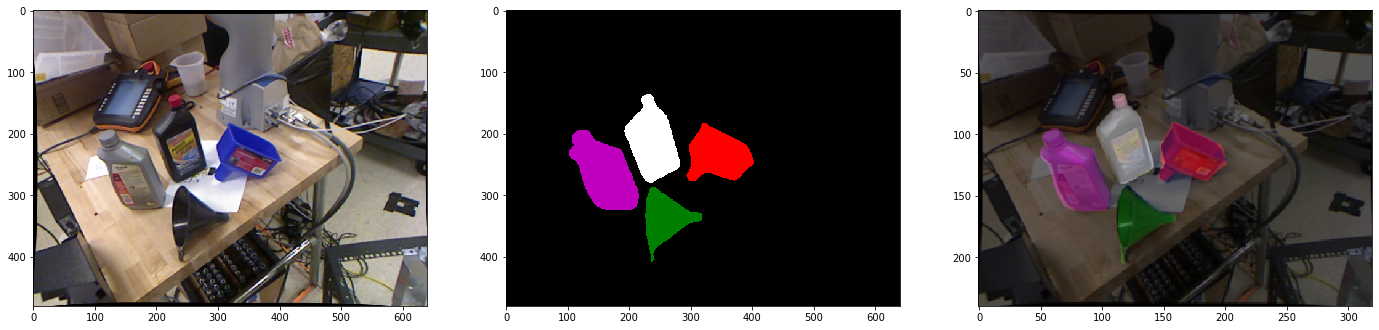

detected objects: ['oil_bottle', 'fluid_bottle', 'funnel', 'blue_funnel']



In [12]:
# display random sets of (input image, segmentation, and pose predictions)
count = 0
num_examples = 4

with torch.no_grad():
    for input in val_loader:
        assert input.size(0) == 1  # batch size 1
        segm, object_names, positions, orientations = model(input)

        fig, axes = plt.subplots(1, 3, figsize=(3 * 8, 8))
        image = input[0].permute(1, 2, 0).numpy()
        axes[0].imshow(image)

        # visualize segmentation
        segm = (255.0 * object_colormap[segm]).astype(np.uint8)
        axes[1].imshow(segm)

        # visualize pose estimates
        resized_image = Image.fromarray((255.0 * image).astype(np.uint8)).resize((320, 240), Image.BILINEAR)
        resized_image = np.array(resized_image, np.float32)
        all_objects = np.zeros_like(resized_image)
        for i, object_name in enumerate(object_names):
            single_object = pose_renderers[object_names[i]].render(positions[i], orientations[i])
            all_objects = np.maximum(all_objects, single_object * object_colors[object_names[i]])
        rendered_pose = (1 - alpha) * resized_image + alpha * all_objects
        axes[2].imshow(rendered_pose.astype(np.uint8))

        plt.show()

        print('detected objects: {}'.format(object_names))
        print('')

        count += 1
        if count == num_examples:
            break